In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import dask.array as da
from glob2 import glob
import tqdm.auto
import h5py 
import sparse
from scipy.ndimage.filters import maximum_filter

np.set_printoptions(precision=2, suppress=True, linewidth=150, edgeitems=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
pcs=[]
lbls=[]
filelist=[0, 2, 8, 11, 14]
for file in filelist:
    f=h5py.File(f"ParticleList/{file:03}.h5", 'r')
    pcs.append(f['Particles'])
    lbls.append(f['Labels'])
    
apcs= da.concatenate(pcs)
labels= da.concatenate(lbls)
shap=apcs.shape

apcs=apcs.reshape(shap[0]*shap[1], shap[2])
aidx=da.from_array(expand_dims(repeat(arange(shap[0]), shap[1]), axis=1)) # particle index
ailab=da.from_array(expand_dims(repeat(argmax(labels, axis=1), shap[1]), axis=1)) # particle index
apc=da.concatenate([ aidx, apcs, ailab], axis=1 )
apc

dask.array<concatenate, shape=(24030000, 21), dtype=float64, chunksize=(801000, 19), chunktype=numpy.ndarray>

In [3]:
columns = ['x', 'Energy', 'Px', 'Py', 'Pz', 'Pt', 'Eta', 'Phi', 
                    'vtxX', 'vtxY', 'vtxZ',
                    'ChPFIso', 'GammaPFIso', 'NeuPFIso',
                    'isChHad', 'isNeuHad', 'isGamma', 'isEle',  'isMu',
                    'Charge', 'labels']
boolcols=["isChHad", "isNeuHad", "isGamma"]
goodcol=['x', 'Energy', 'Pt', 'Eta', 'Phi', 'labels']+boolcols


df = dd.from_array(apc, columns=columns)
df = df.loc[~(df[['Px', 'Py', 'Pz']]==0).all(axis=1)]
df2=df[goodcol].compute()
df2=df2[(df2.isChHad==True) | (df2.isNeuHad==True) | (df2.isGamma==True)]
df2["pcType"]=pd.Categorical(df2[boolcols].idxmax(axis=1), categories=boolcols, ordered=True)
df2=df2[df2.pcType.isin(["isChHad", "isNeuHad", "isGamma"])]

In [4]:
def appquantiles(x):
    out, bins= pd.qcut(x, 6, retbins=True, labels=False)
    print(bins)
    return out

df2["ptq"]=df2.groupby("pcType")['Pt'].apply(appquantiles)

df2["ptqg"], bins=pd.qcut(df2['Pt'], 6, retbins=True, labels=False)
df2.head()

[   0.5     0.63    0.78    0.97    1.23    1.73 1006.65]
[  1.     1.14   1.32   1.56   1.93   2.66 489.1 ]
[  1.     1.1    1.23   1.41   1.7    2.3  794.75]


,x,Energy,Pt,Eta,Phi,labels,isChHad,isNeuHad,isGamma,pcType,ptq,ptqg
0,0.0,94.892776,1.409589,-4.902542,-1.992827,0.0,0.0,1.0,0.0,isNeuHad,2,3
1,0.0,458.120385,7.542172,-4.799701,-2.128332,0.0,0.0,1.0,0.0,isNeuHad,5,5
2,0.0,381.731567,6.125896,-4.825275,-1.922774,0.0,0.0,0.0,1.0,isGamma,5,5
3,0.0,126.327881,2.035756,-4.821096,2.816401,0.0,0.0,1.0,0.0,isNeuHad,4,4
4,0.0,90.711220,1.758054,-4.636527,-1.698120,0.0,0.0,1.0,0.0,isNeuHad,3,4


In [23]:
nbinseta=250
nbinsphi=150
etabins=linspace(-5,  5,  nbinseta+1)
phibins=linspace(-pi, pi, nbinsphi+1)
ycat={"isGamma": 0, "isChHad": 1, "isNeuHad": 2}

ifilter=9
allcanv=[]

def getcanvas(df):
    for name, gp in tqdm.auto.tqdm(df.groupby(["x"])):
        canvas=np.zeros([1000, 900], dtype=bool)
        for name2, gp2 in gp.groupby(["pcType", "ptq"]):
            if len(gp2)==1: continue
            y, x= ycat[name2[0]], name2[1]
            histo, xe, ye=histogram2d(gp2["Eta"], gp2["Phi"], weights=gp2["Pt"], bins=[etabins, phibins ])
            for i in range(0, x+1):
                xo=nbinsphi*i
                yo=y*nbinseta
                canvas[yo:yo+nbinseta, xo:xo+nbinsphi]+=maximum_filter(histo>0, ifilter)
        for x, gp2 in gp.groupby(["ptqg"]):
            if len(gp2)==1: continue
            histo, xe, ye=histogram2d(gp2["Eta"], gp2["Phi"], weights=gp2["Pt"], bins=[etabins, phibins ])
            for i in range(0, int(x)+1):
                xo=nbinsphi*i
                yo=3*nbinseta
                canvas[yo:yo+nbinseta, xo:xo+nbinsphi]+=maximum_filter(histo>0, ifilter)
        allcanv.append(canvas)
    return allcanv

getcanvas(df2.iloc[:2000*500])

[array([[False, False, False, False, False, ..., False, False, False, False, False],
        [False, False, False, False, False, ..., False, False, False, False, False],
        [False, False, False, False, False, ..., False, False, False, False, False],
        [False, False, False, False, False, ..., False, False, False, False, False],
        [False, False, False, False, False, ..., False, False, False, False, False],
        ...,
        [ True,  True,  True,  True,  True, ..., False, False, False, False, False],
        [ True,  True,  True,  True,  True, ..., False, False, False, False, False],
        [ True,  True,  True,  True,  True, ..., False, False, False, False, False],
        [ True,  True,  True,  True,  True, ..., False, False, False, False, False],
        [ True,  True,  True,  True,  True, ..., False, False, False, False, False]]),
 array([[False, False, False, False, False, ..., False, False, False, False, False],
        [False, False, False, False, False, ..., F

In [22]:
shape(allcanv)

(4, 1000, 900)

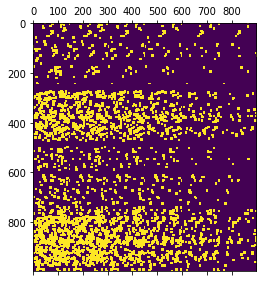

In [19]:
matshow(allcanv[10])

In [20]:
size(allcanv)

577800000